# Домашнее задание «Сегментация и детекция объектов»

Распознавание рукописного ввода на примере базы MNIST
Построить классификатор изображений рукописного ввода на базе MNIST. В качестве
шаблона в данной работе можно использовать ipython-ноутбук [002-digit.ipynb](https://github.com/a4tunado/lectures/blob/master/002/002-digit.ipynb).
Классификатор предлагается строить на признаках, полученных в результате предобработки
изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.
В качестве модели классификатора можно использовать любую известную Вам модель, за
исключением сверточных нейронных сетей.
Критерием качества классификатора является метрика accuracy. Для получения зачета по
данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на
тестовой выборке в рамках контеста [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) на Kaggle.
Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса
построения модели и скриншота с финальным результатом на Kaggle.

## Загрузка бибилотек

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

## Загрузка данных

In [7]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

## Определение признаков и целевой переменной

In [9]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [10]:
train_img.shape

(42000, 28, 28)

## Визуализация исходных данных

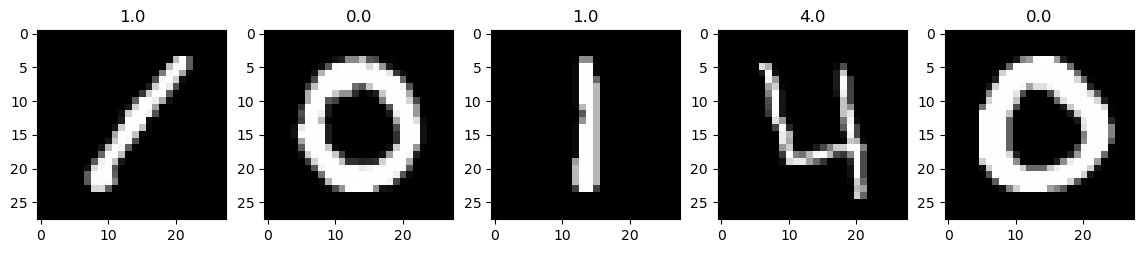

In [12]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [14]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [15]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [17]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [18]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

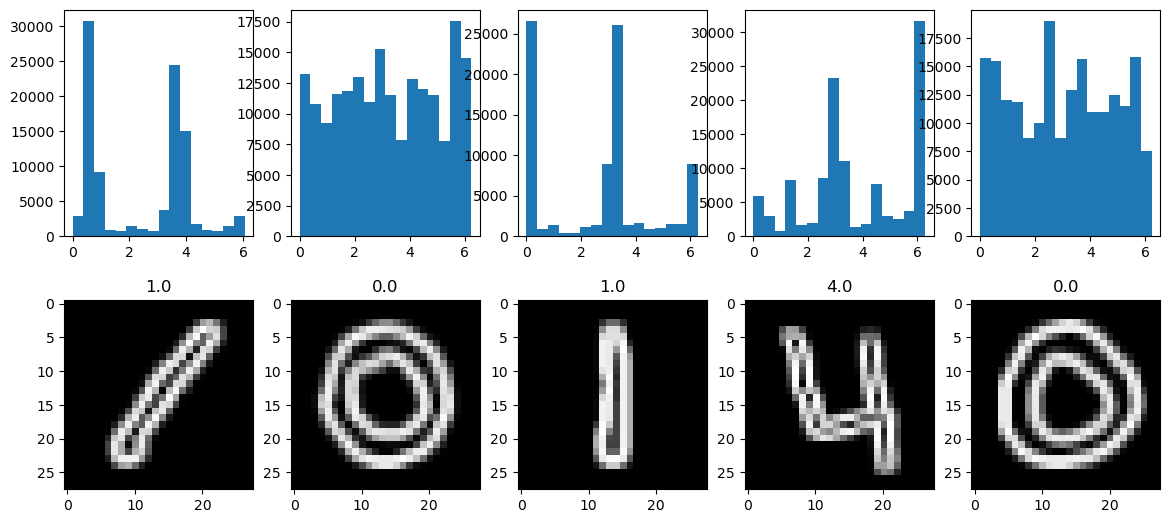

In [19]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [21]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [22]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [24]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [25]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Параметры HOG дискриптора

In [27]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

In [28]:
train_descriptor = np.zeros((len(train_img), 144))
for i in range(len(train_img)):
    train_descriptor[i] = hog.compute(np.uint8(train_img[i])).reshape(-1)

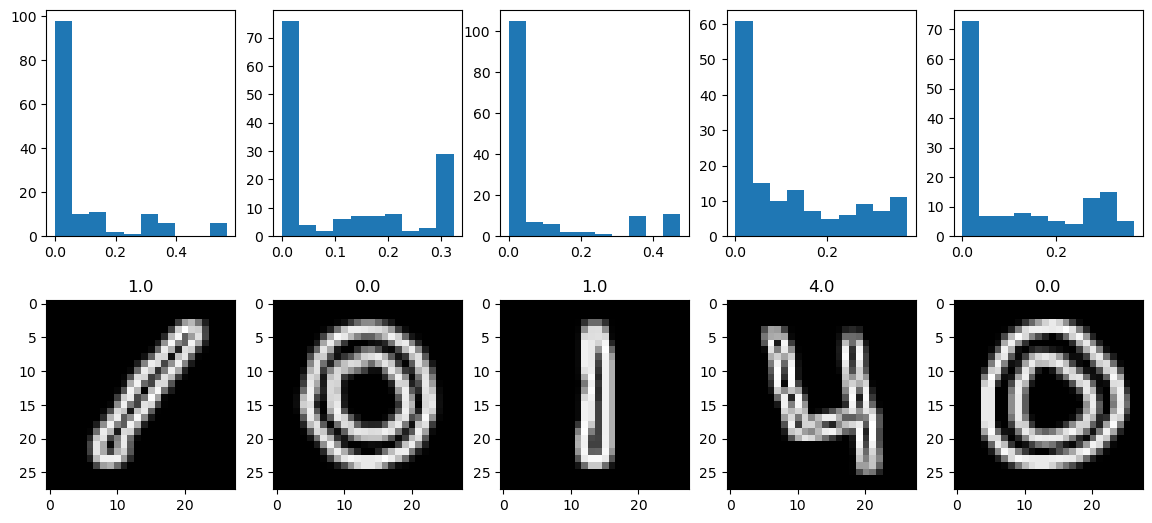

In [29]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_descriptor[i-1].flatten())

## Определение выборки на обучающую и тестовую выборки

In [31]:
y_train, y_val, x_train, x_val = train_test_split(train_label,
                                                  train_descriptor,
                                                  test_size=0.2,
                                                  random_state=42)

## Обучение модели с помощью опорных векторов на HOG дескрипторе

In [33]:
classifier = svm.SVC(kernel='linear', C=1.0)
classifier.fit(x_train, y_train)

SVC(kernel='linear')

In [34]:
y_predict = classifier.predict(x_val)

## Оценка качества

In [36]:
# общая точность
print("Accuracy:", np.round(accuracy_score(y_val, y_predict), 2))

Accuracy: 0.97


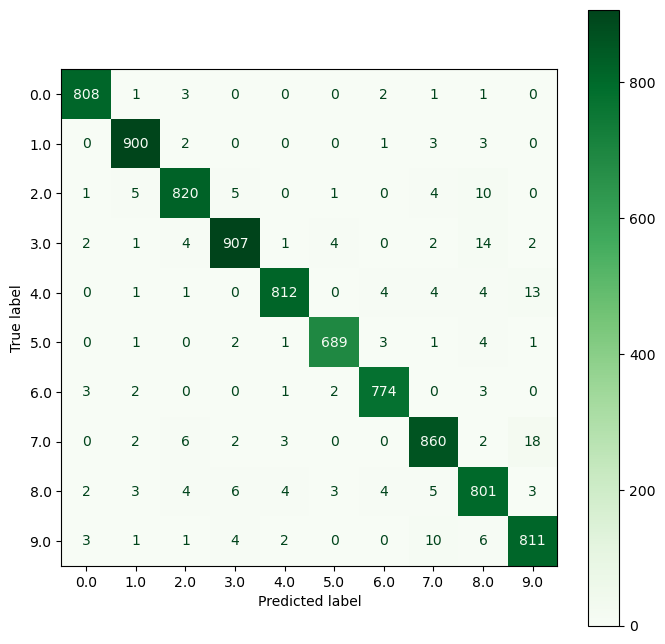

In [37]:
# точность покаждой целевой переменной

# пространство нужного размера для матрицы
fig, ax = plt.subplots(figsize = (8, 8))

metrics.ConfusionMatrixDisplay.from_estimator(classifier, x_val, y_val, cmap = plt.cm.Greens, ax = ax)

# Формирование файла для проверки в Каггл

In [39]:
test_descriptor = np.zeros((len(test_img), 144))
for i in range(len(test_img)):
    test_descriptor[i] = hog.compute(np.uint8(test_img[i])).reshape(-1)

with open('submit_HOG.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(classifier.predict(test_descriptor), 1):
        dst.write('%s,%s\n' % (i, int(p)))

# Загрузка скриншота с Каггла

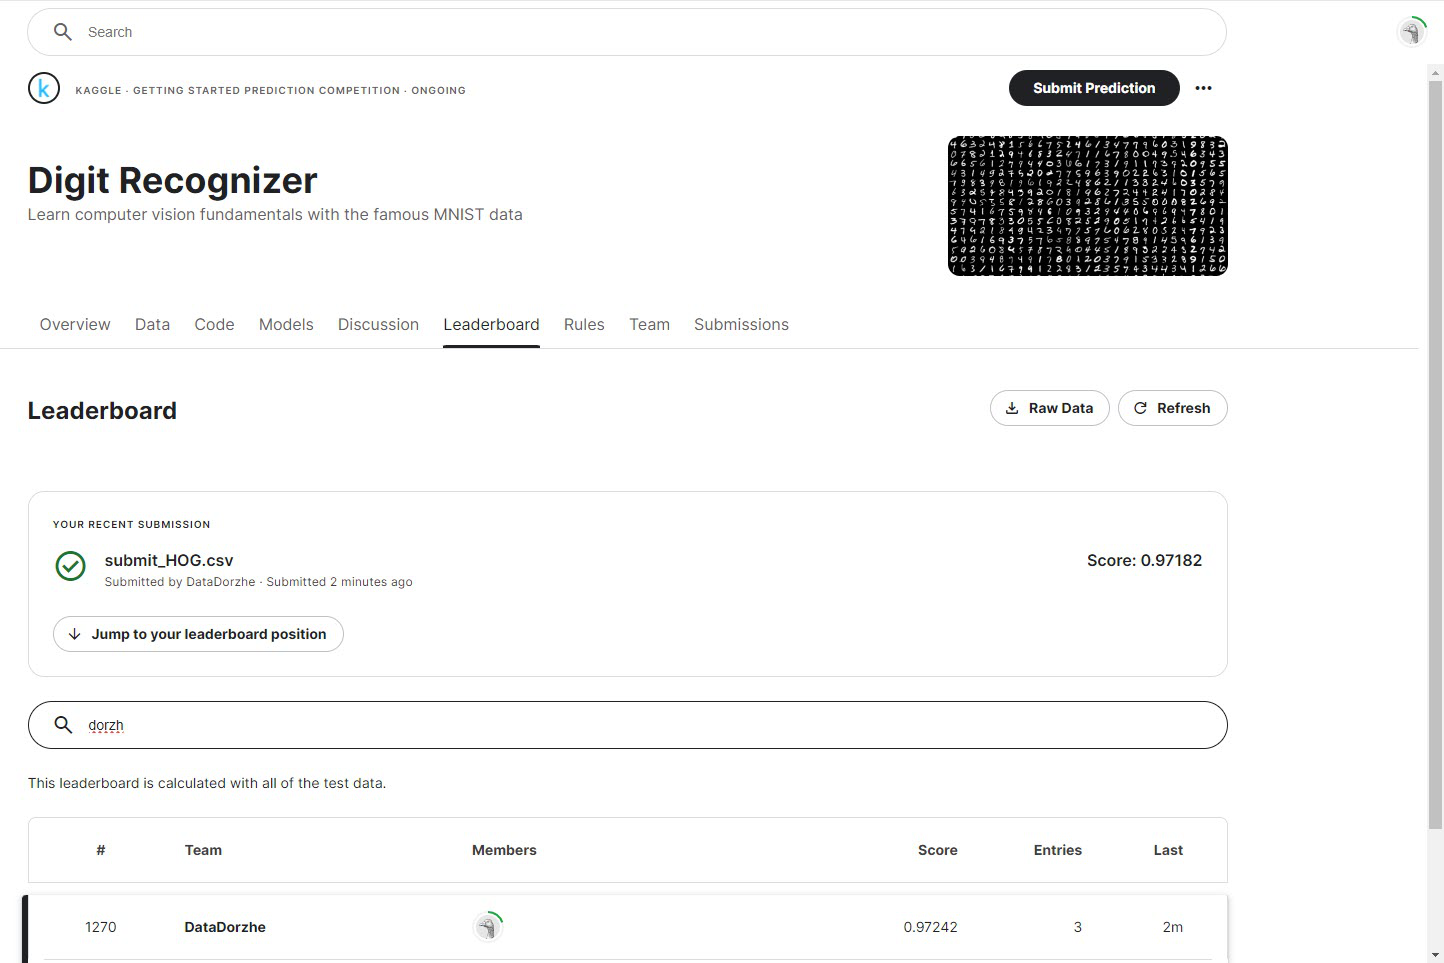

In [41]:
from PIL import Image
Image.open('DataDorzhe_Digit_Score_HOG.jpg')